In [1]:
CIFAR_DIR = '/Users/malhotra/Desktop/my-projects/tensorflow/dataset/cifar-10-batches-py/'

In [2]:
import pickle
def unpickle(file):
    with open(file,'rb') as fo:
        cifar_dict = pickle.load(fo,encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [8]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

In [10]:
x = data_batch1[b'data']

In [11]:
x = x.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")

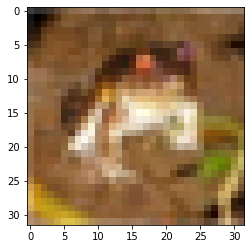

In [12]:
plt.imshow(x[0])

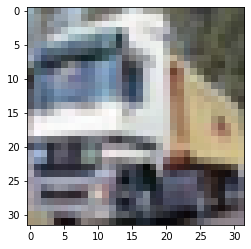

In [13]:
plt.imshow(x[1])

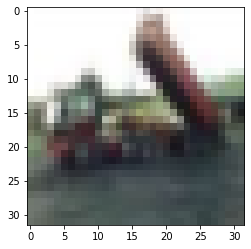

In [14]:
plt.imshow(x[2])

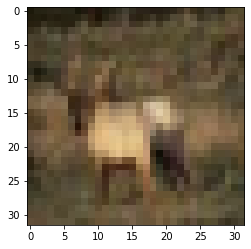

In [15]:
plt.imshow(x[3])

In [16]:
# Helper functions for dealing with data
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [17]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None

    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [19]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


# CREATING THE MODEL

In [20]:
import tensorflow as tf

In [21]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [22]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

In [23]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [24]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [26]:
8*8*64

4096

In [27]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [28]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [29]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
y_pred = normal_full_layer(full_one_dropout,10)

In [31]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [33]:
init = tf.global_variables_initializer()

In [1]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

NameError: name 'tf' is not defined